<a href="https://colab.research.google.com/github/Elhameed/Sound-Clustering/blob/main/Teniola_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
#Make allNecessary Imports
from google.colab import drive
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the sound data
unlabelled_data_path = "/content/drive/MyDrive/unlabelled_sounds"
sound_files = librosa.util.find_files(unlabelled_data_path)

# Extract Mel Spectrogram features
features = []
for file in sound_files:
    y, sr = librosa.load(file)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    features.append(np.mean(mel_spectrogram, axis=1))

features_array = np.array(features)

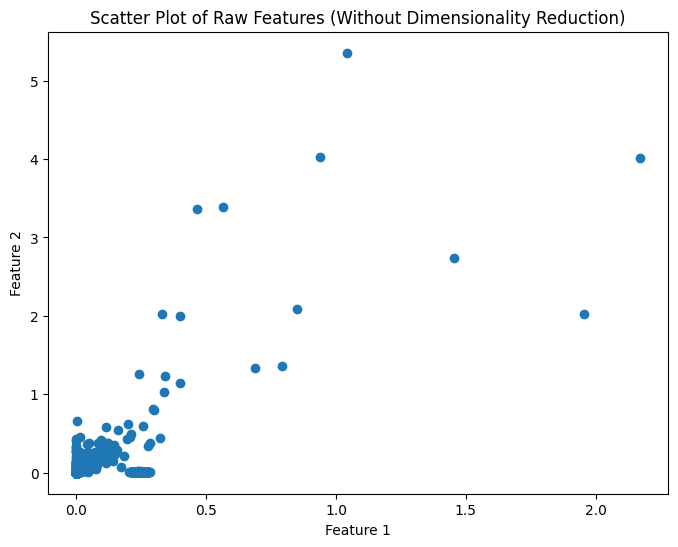

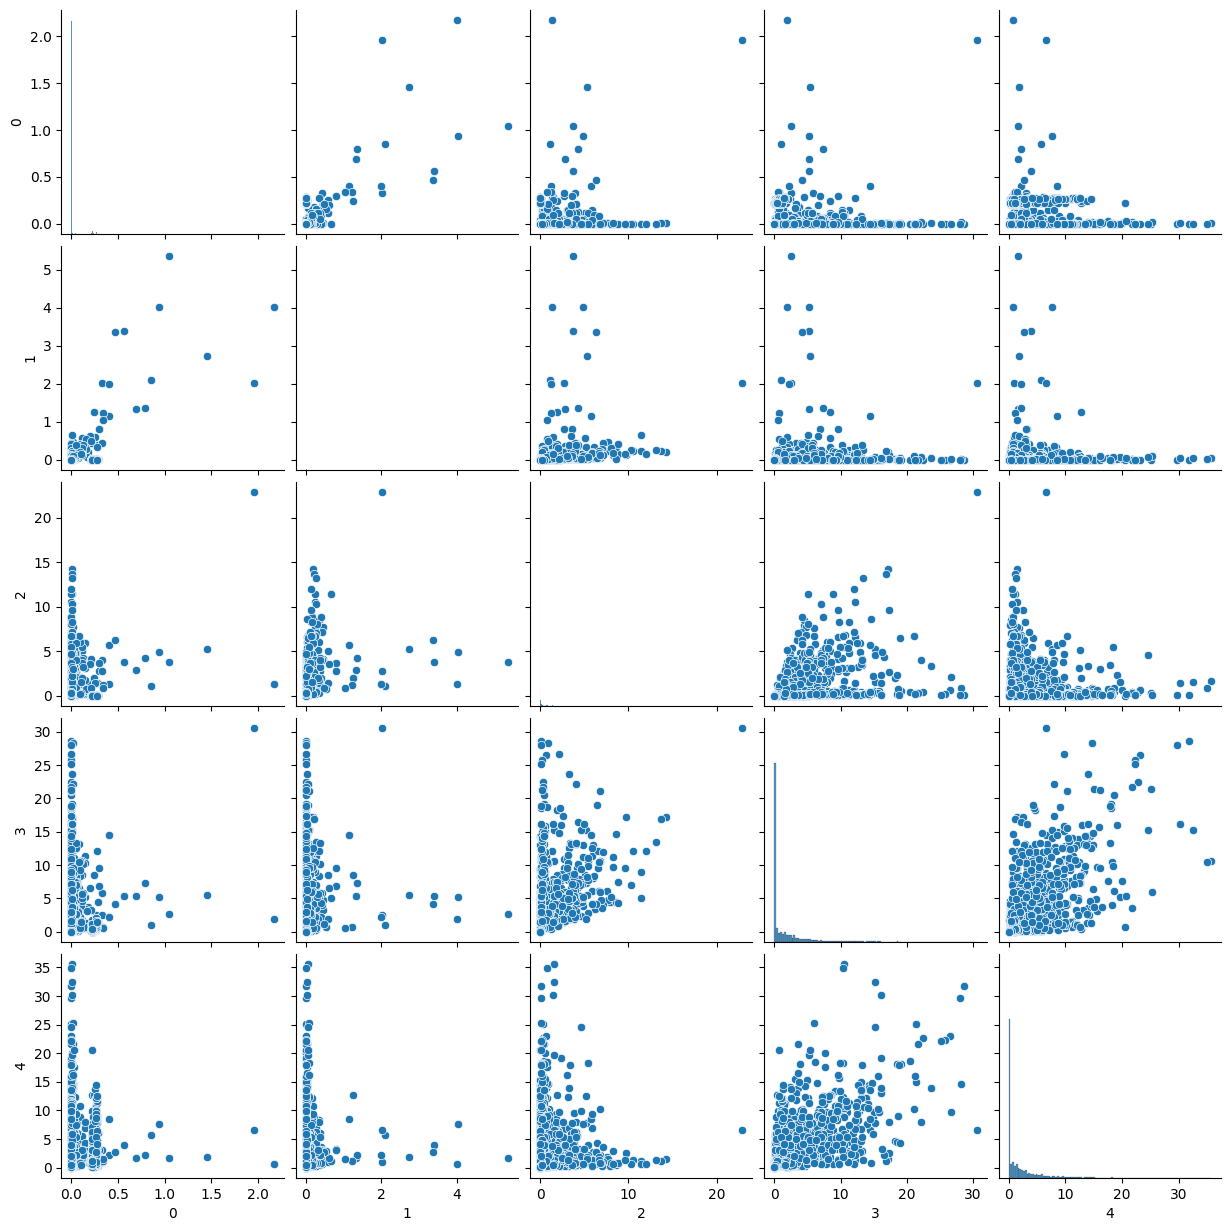

In [4]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
import pandas as pd
df = pd.DataFrame(features_array[:, :5])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
Dimensionality reduction is important because the initial visualizations of the raw features (without dimensionality reduction) showed significant challenges. In the scatter plot and pair plot, the data points were heavily overlapping and cluttered, making it impossible to identify any clear patterns or clusters. This is a direct result of the **curse of dimensionality**, where high-dimensional data becomes sparse and distances between points lose meaning, leading to skewed distributions and poor clustering performance.

Additionally, the presence of redundant and noisy features in the high-dimensional data further degraded the quality of the visualizations and made clustering less effective. For example, the scatter plot of raw features showed no clear separation between data points, and the pair plot revealed overlapping distributions across multiple features.

Dimensionality reduction techniques like **PCA** and **t-SNE** address these issues by projecting the data into a lower-dimensional space while preserving the most important patterns. After applying t-SNE, the data points were clearly separated into distinct clusters, making it easier to interpret the data and identify meaningful structures. This not only improves visualization but also enhances the performance of clustering algorithms by reducing noise and computational cost.

In summary, dimensionality reduction is essential for overcoming the challenges of high-dimensional data, as demonstrated by the cluttered and uninterpretable visualizations of the raw features. By reducing dimensions, we can reveal hidden patterns, improve clustering accuracy, and make the data more manageable.

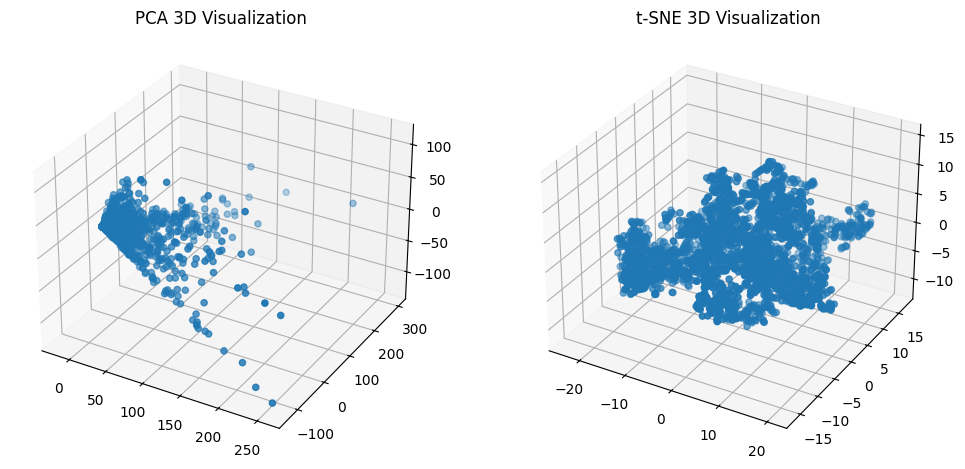

In [5]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# PCA 3D Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2])
ax1.set_title("PCA 3D Visualization")

# t-SNE 3D Plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2])
ax2.set_title("t-SNE 3D Visualization")

plt.show()



### Which method (PCA or t-SNE) provides better separability of clusters and why?
Based on the visualization, the t-SNE plot (right) provides better separability of clusters compared to the PCA plot (left). In the PCA visualization, the data points appear more spread out, with no clear cluster formations, which indicates that PCA primarily captures variance rather than grouping similar data points together. In contrast, the t-SNE visualization shows more compact and well-defined groupings, suggesting that it preserves local structures and effectively reveals underlying clusters in the data. Since t-SNE is a non-linear dimensionality reduction technique, it is better suited for uncovering hidden patterns in high-dimensional data, whereas PCA, being a linear method, is more focused on preserving global variance. Therefore, based on the provided plots, t-SNE demonstrates superior cluster separability, making it a more suitable choice for visualizing inherent groupings in the dataset.

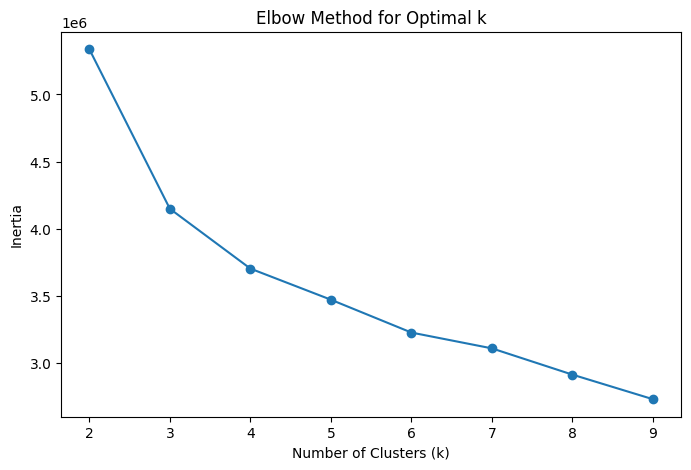

In [6]:
# Optimize number of clusters using Elbow Method
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


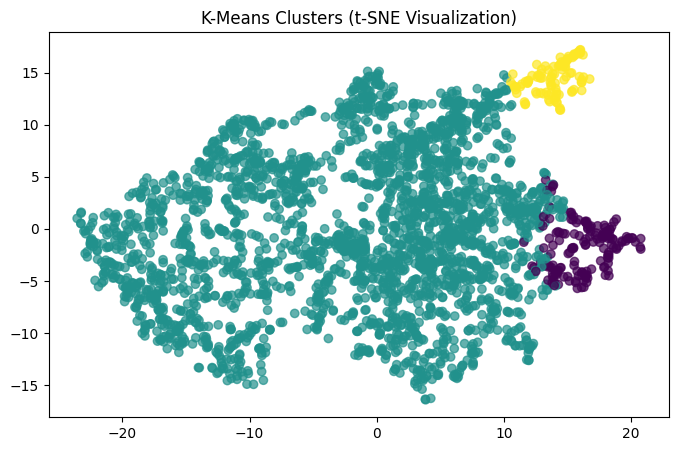

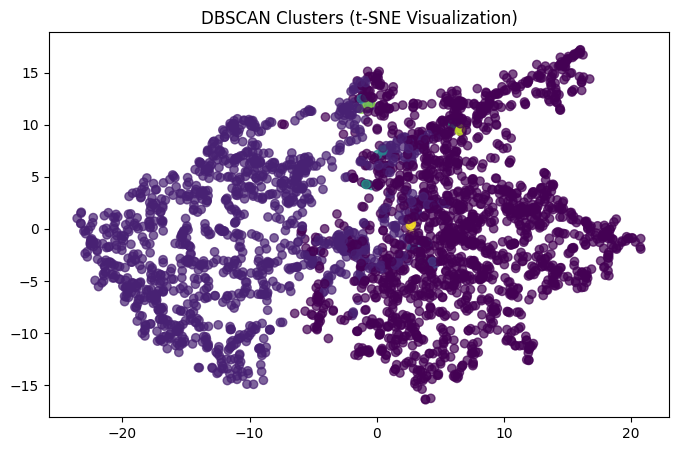

In [7]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clusters (t-SNE Visualization)")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.title("DBSCAN Clusters (t-SNE Visualization)")
plt.show()

In [8]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.7005, Davies-Bouldin Index: 1.0313
DBSCAN - Silhouette Score: -0.0305, Davies-Bouldin Index: 1.8554


### Discuss the results (max 5 lines)
The results indicate that K-Means clustering performed better than DBSCAN for this dataset. The t-SNE visualization of K-Means shows well-separated clusters, particularly highlighting a distinct yellow cluster, while DBSCAN failed to form meaningful clusters, as most points are assigned to the same category. The silhouette score of K-Means (0.7005) suggests good cluster cohesion and separation, whereas DBSCAN's silhouette score (-0.0305) and high Davies-Bouldin Index (1.8554) indicate poor clustering performance. The Elbow Method graph suggests an optimal k of around 3, reinforcing that K-Means is more suitable for this dataset than DBSCAN.

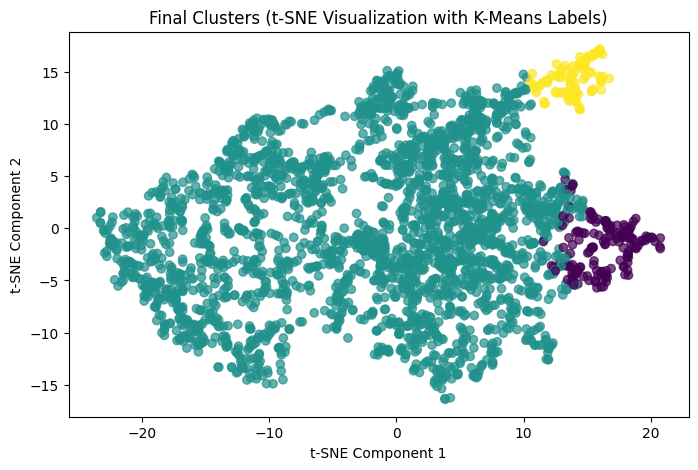

In [9]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

1. Dimensionality reduction, specifically t-SNE, played a crucial role in visualizing the clusters effectively, but it did not directly improve the clustering performance. Since t-SNE is a non-linear dimensionality reduction technique optimized for visualization rather than preserving global structures, it helped us observe how the clusters were formed but did not enhance the clustering algorithms themselves. However, reducing high-dimensional data often benefits clustering by eliminating noise and redundant features, making the clustering process more efficient and interpretable.

2. K-Means performed significantly better than DBSCAN, as evidenced by the well-defined clusters in the t-SNE visualization and the superior silhouette score (0.7005 vs. -0.0305). The Elbow Method also provided a clear indication of the optimal number of clusters (k ≈ 3), further reinforcing K-Means’ effectiveness. DBSCAN struggled due to its density-based approach, which is highly sensitive to parameter tuning (eps, min_samples). Given the dataset’s distribution, DBSCAN failed to differentiate meaningful clusters, classifying most points into a single category. This suggests that K-Means' centroid-based method was better suited for this dataset, where clusters were more globular rather than varying in density.

3. These findings reflect real-world clustering challenges, where the choice of algorithm depends heavily on the dataset structure. In practical applications like customer segmentation, anomaly detection, or medical diagnosis, selecting the wrong clustering technique can lead to misleading insights. For instance, DBSCAN is excellent for identifying anomalies and irregularly shaped clusters, such as fraud detection, but struggles with overlapping and dense datasets like ours. Meanwhile, K-Means, despite its simplicity, remains effective for well-separated clusters, making it a preferred choice in market segmentation and recommendation systems. Understanding these nuances is essential for applying clustering techniques in real-world scenarios.